Big Data en R: una guía de campo para el profesional y el investigador
===

Juan David Velásquez Henao, MSc, PhD

Facultad de Minas

Universidad Nacional de Colombia, Sede Medellín

## El paradigma MapReduce

![hadoop-mapreduce](assets/hadoop-mapreduce.jpg)

## Conteo de palabras usando MapReduce

### Datos

In [1]:
!rm -rf input
!mkdir input

In [2]:
%%writefile input/text0.txt
A B C A
A D D A
A K M C

Writing input/text0.txt


In [3]:
%%writefile input/text1.txt
B A C Y B
U O Y Y A
A B I T

Writing input/text1.txt


In [4]:
%%writefile input/text2.txt
A C D A
A K B
A N H I D A

Writing input/text2.txt


### Algoritmo

![map-reduce](assets/map-reduce.jpg)

### Implementación

#### mapper.R

In [5]:
%%writefile mapper.R
#! /usr/bin/env Rscript

input <- file('stdin', 'r')
while(TRUE) {
    row <- readLines(input, n=1)
    if( length(row) == 0 ){
        break
    }
    words <- strsplit(row, " ")[[1]]
    for(word in words){
        if(word != '')
            write(cat(word,'\t1',sep=''), "")
    }
}

Overwriting mapper.R


In [6]:
## El programa anterior se hace ejecutable
!chmod +x mapper.R

## Verificación
!cat ./input/text*.txt | ./mapper.R | head

A	1
B	1
C	1
A	1
A	1
D	1
D	1
A	1
A	1
K	1
Error in cat(word, "\t1", sep = "") : ignoring SIGPIPE signal
Calls: write -> cat -> cat
Execution halted


#### reducer.R

In [7]:
%%writefile reducer.R
#!/usr/bin/env Rscript

curkey <- NULL
total <- 0
input <- file('stdin', 'r')
while(TRUE) {
    row <- readLines(input, n=1)
    if( length(row) == 0 ){
        break
    }
    x <- strsplit(row, "\t")[[1]]
    key <- x[1]
    value <- strtoi(x[2])
    if(!is.null(curkey) && key == curkey){
        total <- total + value
    }
    else{
        if( !is.null(curkey) ) {
            write(cat(curkey,'\t', total), "")
        }
        curkey <- key
        total <- value
    }
}
write(cat(curkey,'\t', total), "")

Overwriting reducer.R


In [8]:
!chmod +x reducer.R
!cat ./input/text*.txt | ./mapper.R | sort | ./reducer.R 

A 	 13
B 	 5
C 	 4
D 	 4
H 	 1
I 	 2
K 	 2
M 	 1
N 	 1
O 	 1
T 	 1
U 	 1
Y 	 3


#### Ejecución en Hadoop

In [9]:
!hdfs dfs -rm -r -f /tmp/wordcount/input
!hdfs dfs -mkdir /tmp/wordcount/input
!hdfs dfs -copyFromLocal  input/* /tmp/wordcount/input
!hdfs dfs -ls /tmp/wordcount/input/*

Deleted /tmp/wordcount/input
-rw-r--r--   1 vagrant supergroup         24 2019-06-20 18:45 /tmp/wordcount/input/text0.txt
-rw-r--r--   1 vagrant supergroup         28 2019-06-20 18:45 /tmp/wordcount/input/text1.txt
-rw-r--r--   1 vagrant supergroup         26 2019-06-20 18:45 /tmp/wordcount/input/text2.txt


In [10]:
##
## Se borra la carpeta de salida si existe
##
!hdfs dfs -rm -r -f /tmp/wordcount/output

##
## Se lanza el proceso en el cluster
##
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
    -input   /tmp/wordcount/input   \
    -output  /tmp/wordcount/output  \
    -file    mapper.R reducer.R     \
    -mapper  mapper.R               \
    -reducer reducer.R

Deleted /tmp/wordcount/output
packageJobJar: [mapper.R, reducer.R, /tmp/hadoop-unjar6469148254629004813/] [] /tmp/streamjob1946450967712389098.jar tmpDir=null


#### Resultados

In [11]:
##
## Contenido del directorio de salida
##
!hadoop fs -ls /tmp/wordcount/output

Found 2 items
-rw-r--r--   1 vagrant supergroup          0 2019-06-20 18:45 /tmp/wordcount/output/_SUCCESS
-rw-r--r--   1 vagrant supergroup         79 2019-06-20 18:45 /tmp/wordcount/output/part-00000


In [12]:
!hadoop fs -cat /tmp/wordcount/output/part-00000

A 	 13
B 	 5
C 	 4
D 	 4
H 	 1
I 	 2
K 	 2
M 	 1
N 	 1
O 	 1
T 	 1
U 	 1
Y 	 3


## Evolución del Big Data

![evolucion-bigadata](assets/evolucion-bigadata.jpg)

## Posicionamiento del lenguaje R en el mundo

![ieee.jpg](assets/ieee.jpg)

## Ecosistema de aplicaciones

![ecosistema](assets/ecosistema.jpg)

## Aprendizaje estadístico y aprendizaje de máquinas en Big Data

![hadoop-spark](assets/hadoop-spark.jpg)

## SparkR (Spark on R from Apache)

### Conteo de palabras en sparkR (the spark way)

In [13]:
%load_ext rpy2.ipython

In [14]:
%%R
library(SparkR)
sparkR.session(enableHiveSupport = TRUE)

R[write to console]: 
Attaching package: ‘SparkR’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window


R[write to console]: The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union


R[write to console]: Spark package found in SPARK_HOME: /usr/local/spark-2.4.0



Launching java with spark-submit command /usr/local/spark-2.4.0/bin/spark-submit   sparkr-shell /tmp/RtmpoIy76h/backend_port33fb7c89c102 
Java ref type org.apache.spark.sql.SparkSession id 1 


In [15]:
%%R
text <- read.df(
    path = '/tmp/wordcount/input/',    # hdfs    
    source = 'text',                   # tipo: csv, text, json
    schema = NULL,                     # tipos de columnas 
    na.strings = "NA")                 # null

collect(text)

        value
1   B A C Y B
2   U O Y Y A
3     A B I T
4     A C D A
5       A K B
6 A N H I D A
7     A B C A
8     A D D A
9     A K M C


In [16]:
%%R
words <- select(text, alias(explode(split_string(text$value, ' ')), 'w'))
head(words)

  w
1 B
2 A
3 C
4 Y
5 B
6 U


In [17]:
%%R
result <- count(groupBy(words, 'w'))
x <- collect(arrange(result, desc(result$count)))
x

   w count
1  A    13
2  B     5
3  D     4
4  C     4
5  Y     3
6  K     2
7  I     2
8  T     1
9  M     1
10 U     1
11 O     1
12 N     1
13 H     1


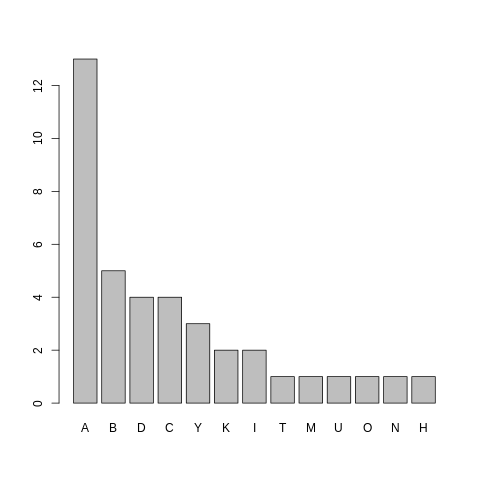

In [18]:
%%R
barplot(x$count, names.arg=x$w)

## Sparklyr from RStudio

In [19]:
%%R
library(sparklyr)
library(dplyr)
sc <- spark_connect(master='local', spark_home='/home/vagrant/spark/spark-2.4.3-bin-hadoop2.7')
spark_version(sc)

R[write to console]: 
Attaching package: ‘sparklyr’


R[write to console]: The following object is masked from ‘package:SparkR’:

    collect


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:SparkR’:

    arrange, between, coalesce, collect, contains, count, cume_dist,
    dense_rank, desc, distinct, explain, expr, filter, first, group_by,
    intersect, lag, last, lead, mutate, n, n_distinct, ntile,
    percent_rank, rename, row_number, sample_frac, select, slice, sql,
    summarize, union


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] ‘2.4.3’


In [20]:
%%R
text <- spark_read_text(
    sc,                        ## spark_connection
    'letters',                 ## nombre de la tabla
    '/tmp/wordcount/input/')   ## ubicación del archivo en el sistema hdfs

text

# Source: spark<letters> [?? x 1]
  line       
  <chr>      
1 B A C Y B  
2 U O Y Y A  
3 A B I T    
4 A C D A    
5 A K B      
6 A N H I D A
7 A B C A    
8 A D D A    
9 A K M C    


In [21]:
%%R
words <- (text %>%  mutate(line=split(line, ' ')) %>% mutate(w = explode(line))) %>% select(w)
words

# Source: spark<?> [?? x 1]
   w    
   <chr>
 1 B    
 2 A    
 3 C    
 4 Y    
 5 B    
 6 U    
 7 O    
 8 Y    
 9 Y    
10 A    
# … with more rows


In [22]:
%%R
words %>% group_by(w) %>% summarize(count = n())

# Source: spark<?> [?? x 2]
   w     count
   <chr> <dbl>
 1 T         1
 2 K         2
 3 N         1
 4 H         1
 5 M         1
 6 B         5
 7 C         4
 8 Y         3
 9 U         1
10 A        13
# … with more rows


In [23]:
%%R
result <- (words %>% group_by(w) %>% summarize(count = n()))
result

# Source: spark<?> [?? x 2]
   w     count
   <chr> <dbl>
 1 T         1
 2 K         2
 3 N         1
 4 H         1
 5 M         1
 6 B         5
 7 C         4
 8 Y         3
 9 U         1
10 A        13
# … with more rows


In [24]:
%%R
x <- collect(result %>% arrange(desc(count)))
x

# A tibble: 13 x 2
   w     count
   <chr> <dbl>
 1 A        13
 2 B         5
 3 C         4
 4 D         4
 5 Y         3
 6 K         2
 7 I         2
 8 T         1
 9 N         1
10 H         1
11 M         1
12 U         1
13 O         1


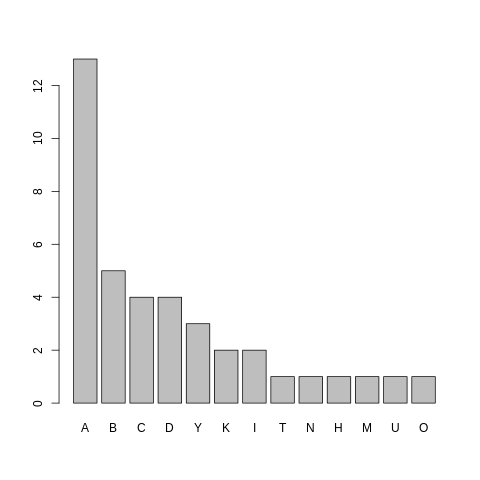

In [25]:
%%R
barplot(x$count, names.arg=x$w)

## Machine Learning: Segmentación de mercados

In [26]:
!hdfs dfs -copyFromLocal snsdata.csv /tmp/snsdata.csv

copyFromLocal: `/tmp/snsdata.csv': File exists


In [27]:
!head snsdata.csv

gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
2006,M,18.982,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2006,F,18.801,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,2,1,0,0,0,6,4,0,1,0,0,0,0,0,0,0,0
2006,M,18.335,69,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006,F,18.875,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2006,NA,18.995,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,1,1,0,3,0,1,0,0,0,1,0,0,0,2,0,0,0,0,0,1,1
2006,F,,142,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2006,F,18.93,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0
2006,M,18.322,17,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2006,F,19.055

In [28]:
%%R
df <- 
spark_read_csv(
    sc,                  ## spark_connection
    'snsdata',           ## nombre de la tabla
    '/tmp/snsdata.csv')  ## ubicación del archivo
                         ## en el sistema hdfs
df

# Source: spark<snsdata> [?? x 40]
   gradyear gender   age friends basketball football soccer softball volleyball
      <int> <chr>  <dbl>   <int>      <int>    <int>  <int>    <int>      <int>
 1     2006 M       19.0       7          0        0      0        0          0
 2     2006 F       18.8       0          0        1      0        0          0
 3     2006 M       18.3      69          0        1      0        0          0
 4     2006 F       18.9       0          0        0      0        0          0
 5     2006 NA      19.0      10          0        0      0        0          0
 6     2006 F      NaN       142          0        0      0        0          0
 7     2006 F       18.9      72          0        0      0        0          0
 8     2006 M       18.3      17          0        0      0        1          0
 9     2006 F       19.1      52          0        0      0        0          0
10     2006 F       18.7      39          0        0      0        0          0
# … w

In [29]:
%%R
##
## Cantidad de registros leidos
##
count(df)

# Source: spark<?> [?? x 1]
      n
  <dbl>
1 30000


In [30]:
%%R
##
## Conteo por género
##
df %>%  group_by(gender) %>% summarize(count = n())

# Source: spark<?> [?? x 2]
  gender count
  <chr>  <dbl>
1 M       5222
2 F      22054
3 NA      2724


In [31]:
%%R
##
## Conteo por género
##
table(df %>% select(gender) %>% collect)


    F     M    NA 
22054  5222  2724 


In [32]:
%%R
##
## Estadísticos por rango de edades
##
summary(df %>% select(age) %>% collect())

      age         
 Min.   :  3.086  
 1st Qu.: 16.312  
 Median : 17.287  
 Mean   : 17.994  
 3rd Qu.: 18.259  
 Max.   :106.927  
 NA's   :5086     


In [33]:
%%R
##
## Agrupamiento usando k-means
##
model <- 
ml_kmeans(
    df,
    ~ friends + basketball + football + soccer + softball + 
      volleyball + swimming + cheerleading + baseball + tennis + 
      sports + cute + sex + sexy + hot + kissed + dance + band + 
      marching + music + rock + god + church + jesus + bible + 
      hair + dress + blonde + mall + shopping + clothes + hollister + 
      abercrombie + die + death + drunk + drugs,
    k = 5,
    max_iter = 100,
    seed = 12345,
    prediction_col = 'cluster'
)

In [34]:
%%R
##
## Pronóstico del cluster de cada grupo
##
fitted <- ml_predict(model, df) %>% collect

In [35]:
%%R
##
## Cantidad de patrones por cluster
##
fitted %>%  group_by(cluster) %>% summarize(count = n())

# A tibble: 5 x 2
  cluster count
    <int> <int>
1       0  3502
2       1 16886
3       2     7
4       3  8994
5       4   611


---

# Gracias por su atención

---

Big Data en R: una guía de campo para el profesional y el investigador
===

Juan David Velásquez Henao, MSc, PhD

Facultad de Minas

Universidad Nacional de Colombia, Sede Medellín